# Groceries Classification

## Dataset description

**The Freiburg Groceries Dataset consists of 5000 256x256 RGB images of 25 food classes.**

[Source of dataset](http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/)

[More deatils](http://www.github.com/PhilJd/freiburg_groceries_dataset)

**Example images:**

![alt text](https://raw.githubusercontent.com/PhilJd/freiburg_groceries_dataset/master/figures/class_overview.png)


## Import modules and data

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from sklearn.model_selection import train_test_split
import itertools
import copy

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms
import torchvision.models as models

In [0]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**We are going to finetune a pretrained model to classify the images.**

[TORCHVISION MODELS](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

## Initialize and reshape the network

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [0]:
# Initialize the model for this run
NUM_CLASSES = 25
MODEL_NAME = 'densenet'
FEATURE_EXTRACT = True
model, input_size = initialize_model(MODEL_NAME, NUM_CLASSES, FEATURE_EXTRACT, use_pretrained=True)
model = model.to(device)
# Print the model we just instantiated
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

## Data preprocessing

In [0]:
BATCH_SIZE = 64
MEAN_NORMALIZATION = [0.485, 0.456, 0.406]
STD_NORMALIZATION = [0.229, 0.224, 0.225]
IMG_SIZE = 256

transform = transforms.Compose([
#                 transforms.Resize(IMG_SIZE),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN_NORMALIZATION, std=STD_NORMALIZATION)
            ])

dataroot = '/content/drive/My Drive/Colab Notebooks/groceries_images'
dataset = datasets.ImageFolder(root=dataroot, transform=transform)

train_size = int(0.7 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [0]:
# Create training, validation and testing dataloaders
dataloaders_dict = {'train': train_loader,
                    'valid': valid_loader,
                    'test' : test_loader}

In [0]:
dataset.idx_to_class = {v: k for k,v in dataset.class_to_idx.items()}

In [76]:
class_num = []
for t in range(25):
    num = len([elm for elm in dataset.targets if elm == t])
    class_num.append((dataset.idx_to_class[t], num))
class_num = sorted(class_num, key=lambda x: x[1], reverse=True)
class_num

[('CANDY', 372),
 ('CHOCOLATE', 307),
 ('JUICE', 302),
 ('COFFEE', 298),
 ('TEA', 283),
 ('CEREAL', 278),
 ('WATER', 262),
 ('JAM', 241),
 ('SPICES', 207),
 ('HONEY', 185),
 ('CHIPS', 181),
 ('SODA', 177),
 ('PASTA', 172),
 ('TOMATO_SAUCE', 171),
 ('NUTS', 168),
 ('MILK', 162),
 ('CAKE', 161),
 ('VINEGAR', 157),
 ('RICE', 150),
 ('OIL', 143),
 ('BEANS', 136),
 ('SUGAR', 118),
 ('FISH', 110),
 ('FLOUR', 109),
 ('CORN', 97)]

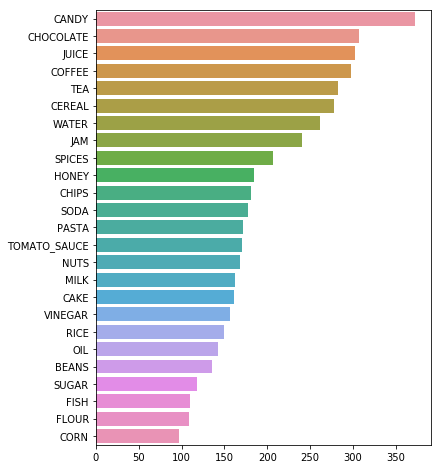

In [78]:
plt.figure(figsize=(6, 8))
name = [elm[0] for elm in class_num]
num = [elm[1] for elm in class_num]
sns.barplot(x=num, y=name)
plt.show()

### Helper function for images display

In [0]:
def imshow(images, rows, cols, figsize):
    images_class = images[1]
    images = images[0].permute(0,2,3,1) # batch_size x rows x cols x channels
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    fig.tight_layout()
    for i, j in itertools.product(range(rows), range(cols)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(rows*cols):
        i = k // cols
        j = k - i*cols
        ax[i, j].cla()
        image = images[k] * torch.tensor(STD_NORMALIZATION) + torch.tensor(MEAN_NORMALIZATION)
        image = image.cpu().data.numpy()
        ax[i, j].imshow(image)
        subtitle = dataset.idx_to_class[images_class[k].item()]
        ax[i, j].set_title(subtitle)
         
    return fig, ax

**Sample images**

In [0]:
img = next(iter(test_loader))

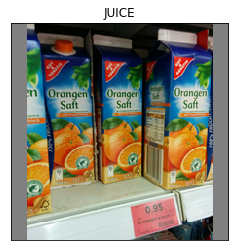

In [0]:
plt.imshow(img[0][-1].permute(1,2,0) * torch.tensor(STD_NORMALIZATION) + torch.tensor(MEAN_NORMALIZATION))
plt.title(dataset.idx_to_class[img[1][-1].item()])
plt.xticks([])
plt.yticks([])
plt.show()

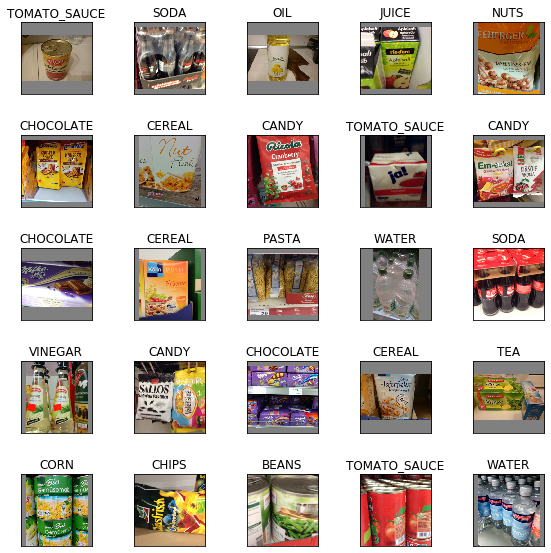

In [0]:
ROWS, COLS = 5, 5
fig, ax = imshow(img, ROWS, COLS, (8,8))
plt.show()

## Model training and evaluation

In [0]:
def train_model(model, 
                dataloaders, 
                criterion, 
                optimizer, 
                num_epochs,
                trn_loss_history=[],
                val_loss_history=[],
                trn_acc_history=[],
                val_acc_history=[],
                is_inception=False
               ):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
            else:
                trn_loss_history.append(epoch_loss)
                trn_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc, trn_loss_history, trn_acc_history, val_loss_history, val_acc_history

### Loss function and optimizer

In [0]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Training loop

In [0]:
NUM_EPOCHS = 100
trn_loss_history = []
val_loss_history = []
trn_acc_history = []
val_acc_history = []

In [0]:
%%time
# Train and evaluate
model, best_acc, trn_loss_history, trn_acc_history, val_loss_history, val_acc_history = train_model(model, 
                                                                                                    dataloaders_dict, 
                                                                                                    criterion, 
                                                                                                    optimizer, 
                                                                                                    NUM_EPOCHS,
                                                                                                    trn_loss_history,
                                                                                                    val_loss_history,
                                                                                                    trn_acc_history,
                                                                                                    val_acc_history,
                                                                                                    is_inception=(MODEL_NAME=="inception")
                                                                                                   )

Epoch 0/99
----------
train loss: 3.0478 acc: 0.1514
valid loss: 2.7637 acc: 0.2649

Epoch 1/99
----------
train loss: 2.5869 acc: 0.3154
valid loss: 2.3984 acc: 0.3670

Epoch 2/99
----------
train loss: 2.2516 acc: 0.4287
valid loss: 2.1429 acc: 0.4317

Epoch 3/99
----------
train loss: 2.0034 acc: 0.5246
valid loss: 1.9489 acc: 0.4995

Epoch 4/99
----------
train loss: 1.8102 acc: 0.5676
valid loss: 1.8152 acc: 0.5571

Epoch 5/99
----------
train loss: 1.6622 acc: 0.6184
valid loss: 1.6838 acc: 0.6047

Epoch 6/99
----------
train loss: 1.5402 acc: 0.6609
valid loss: 1.5998 acc: 0.6117

Epoch 7/99
----------
train loss: 1.4436 acc: 0.6800
valid loss: 1.5333 acc: 0.6107

Epoch 8/99
----------
train loss: 1.3588 acc: 0.6953
valid loss: 1.4644 acc: 0.6481

Epoch 9/99
----------
train loss: 1.2884 acc: 0.7071
valid loss: 1.4125 acc: 0.6491

Epoch 10/99
----------
train loss: 1.2224 acc: 0.7236
valid loss: 1.3688 acc: 0.6593

Epoch 11/99
----------
train loss: 1.1719 acc: 0.7374
valid loss

In [0]:
PATH = './groceries_best.pth'
torch.save({
            'model_state_dict': model.state_dict(),
            'accuracy': best_acc,
            }, PATH)

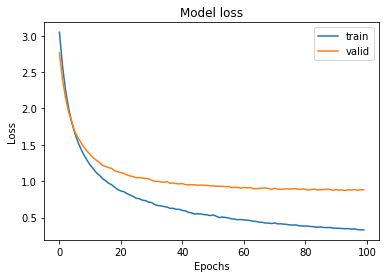

In [0]:
plt.plot(trn_loss_history, label='train')
plt.plot(val_loss_history, label='valid')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')
plt.show()

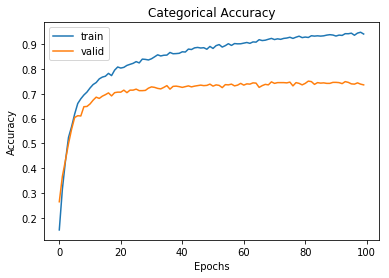

In [0]:
plt.plot(trn_acc_history, label='train')
plt.plot(val_acc_history, label='valid')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Categorical Accuracy')
plt.show()

## Performance evaluation

In [0]:
def test_model(dataloaders_dict, criterion): 
    model.eval()
    phase = 'test'
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders_dict[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad(): outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)
    epoch_acc = running_corrects.double() / len(dataloaders_dict[phase].dataset)
    print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [0]:
%%time
test_loss, test_acc = test_model(dataloaders_dict, criterion)

test loss: 0.8116 acc: 0.7520
CPU times: user 3.11 s, sys: 831 ms, total: 3.94 s
Wall time: 19.5 s


### Examples

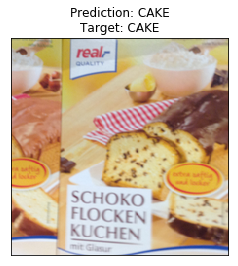

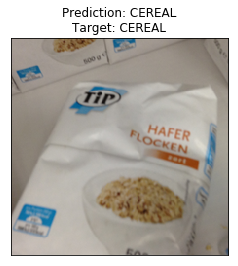

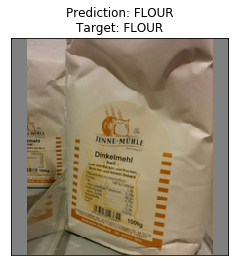

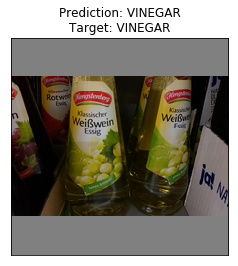

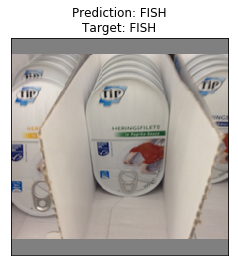

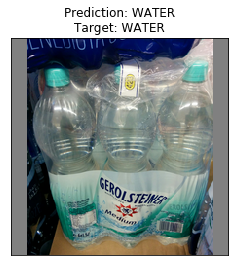

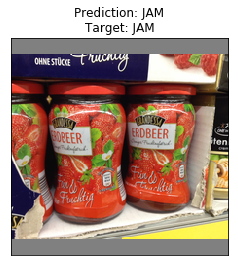

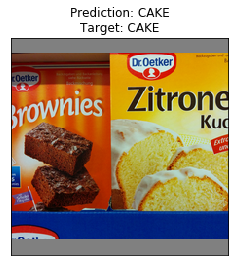

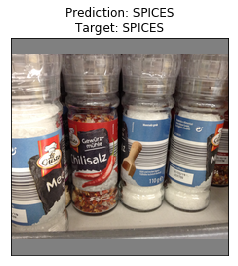

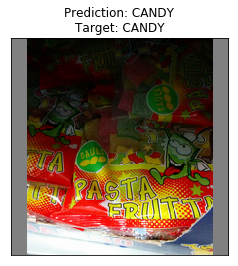

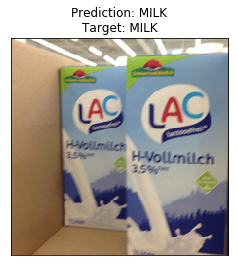

In [43]:
for i, (sample, label) in enumerate(test_dataset):
    sample = sample.to(device)
    with torch.no_grad(): output = model(sample.unsqueeze(0))
    _, pred = torch.max(output, 1)
    pred = pred.item()
    sample = sample.cpu()
    plt.imshow(sample.permute(1,2,0) * torch.tensor(STD_NORMALIZATION) + torch.tensor(MEAN_NORMALIZATION))
    plt.title('Prediction: {pred}\nTarget: {target}'.format(pred=dataset.idx_to_class[pred],
                                                           target=dataset.idx_to_class[label]))
    plt.xticks([])
    plt.yticks([])
    plt.show()
    if i >= 10: break

### Examples of misclassification

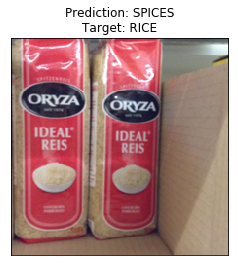

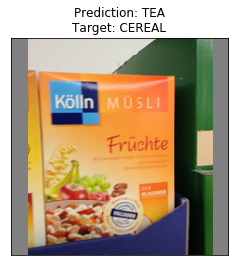

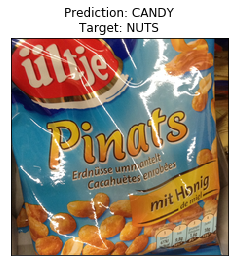

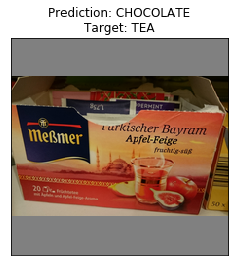

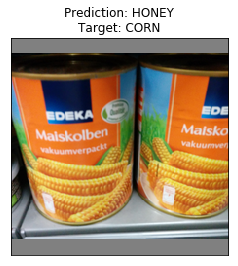

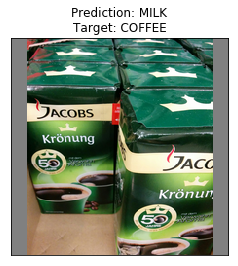

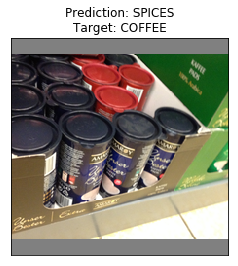

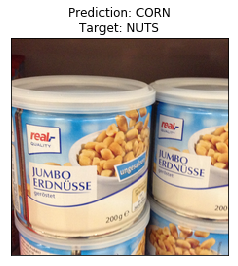

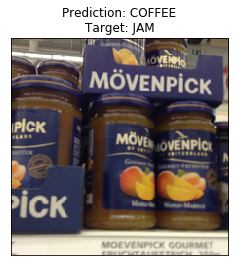

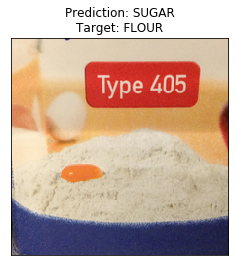

In [49]:
count = 0
for i, (sample, label) in enumerate(test_dataset):
    sample = sample.to(device)
    with torch.no_grad(): output = model(sample.unsqueeze(0))
    _, pred = torch.max(output, 1)
    pred = pred.item()
    if pred != label:
        sample = sample.cpu()
        plt.imshow(sample.permute(1,2,0) * torch.tensor(STD_NORMALIZATION) + torch.tensor(MEAN_NORMALIZATION))
        plt.title('Prediction: {pred}\nTarget: {target}'.format(pred=dataset.idx_to_class[pred],
                                                               target=dataset.idx_to_class[label]))
        plt.xticks([])
        plt.yticks([])
        plt.show()
        count += 1
        if count >= 10: break